In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # Use GPU 1
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/data/home/bowen/projects/prairie_dog_2/yolov5_a100')

from models.common import DetectMultiBackend  # YOLOv5 model loading


/data/bowen/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 512 model

In [2]:
def get_features(image_path, model_path):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DetectMultiBackend(model_path, device=device)
    model.eval()  # Set to evaluation mode

    # 🔹 Load and preprocess the image

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (512, 512))  # YOLOv5 expects 640x640 input
    input_tensor = torch.from_numpy(resized_image).permute(2, 0, 1).float() / 255.0  # Normalize
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and send to device

    # 🔹 Capture feature maps using hooks
    hooks = []
    feature_maps = {}

    def hook_fn(module, input, output):
        hooks.append(output)

    # Attach hooks to the feature pyramid layers (typically layers 4, 6, 8 in YOLOv5)
    layers_to_hook = [model.model.model[2], model.model.model[4], model.model.model[6], model.model.model[17], model.model.model[20], model.model.model[23]]
    layer_names = ["P2 (Small Objects)", "P3 (Small Objects)", "P4 (Medium Objects)", "17", "20", "23"]
    # layer_names = ["P4 concat", "P5 concat"]
    # layers_to_hook = [model.model.model[16], model.model.model[12]]


    for layer, name in zip(layers_to_hook, layer_names):
        layer.register_forward_hook(hook_fn)

    _ = model.model(input_tensor)  # Forward pass to trigger hooks

    # Store feature maps
    for i, name in enumerate(layer_names):
        feature_maps[name] = hooks[i]
        
    return resized_image, feature_maps

In [3]:
%matplotlib inline
def overlay_feature_map(image, feature_map, title, alpha=0.05):
    """Averages all channels in feature map and overlays it on the original image."""
    feature_map = feature_map.squeeze(0).cpu().numpy()  # Remove batch dim, move to CPU
    avg_feature_map = np.mean(feature_map, axis=0)  # Average over all channels
    
    # Print the shape of the feature map
    print(f"Shape of feature map for {title}: {feature_map.shape}")
    
    # Resize feature map to match image size
    avg_feature_map = cv2.resize(avg_feature_map, (image.shape[1], image.shape[0]))
    
    # Normalize feature map to range [0, 255]
    avg_feature_map = (avg_feature_map - avg_feature_map.min()) / (avg_feature_map.max() - avg_feature_map.min()) * 255
    avg_feature_map = avg_feature_map.astype(np.uint8)

    # Apply colormap
    heatmap = cv2.applyColorMap(avg_feature_map, cv2.COLORMAP_JET)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    # Plot the overlay and heatmap side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot overlay
    axes[0].imshow(overlay)
    axes[0].axis("off")
    axes[0].set_title(title)
    
    # Plot heatmap with color bar
    im = axes[1].imshow(avg_feature_map, cmap='jet')
    axes[1].axis("off")
    axes[1].set_title(f"{title} - Heatmap")
    # fig.colorbar(im, ax=axes[1], orientation='vertical')

    plt.show()

Fusing layers... 
YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs


Shape of feature map for P2 (Small Objects): (128, 128, 128)


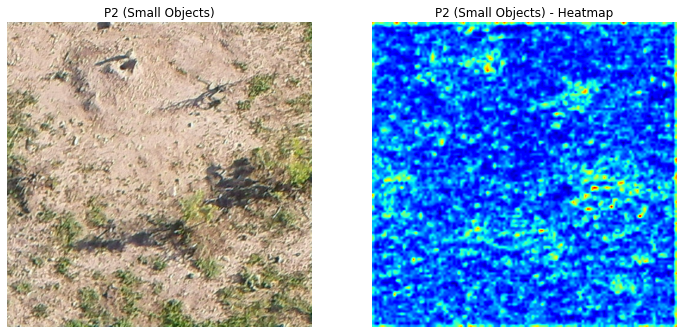

Shape of feature map for P3 (Small Objects): (256, 64, 64)


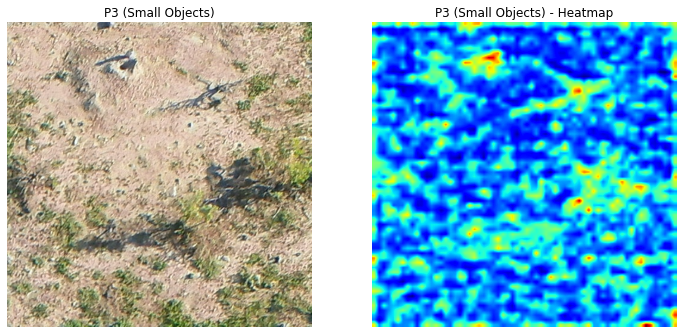

Shape of feature map for P4 (Medium Objects): (512, 32, 32)


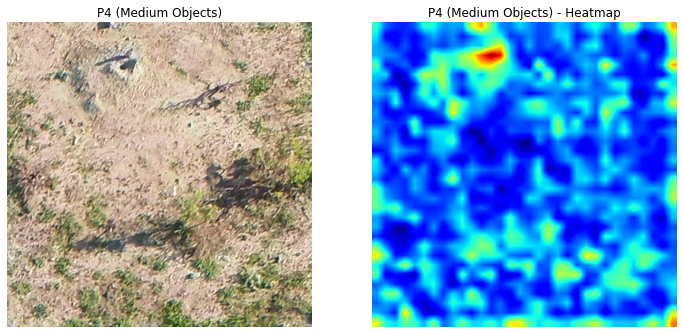

Shape of feature map for 17: (256, 64, 64)


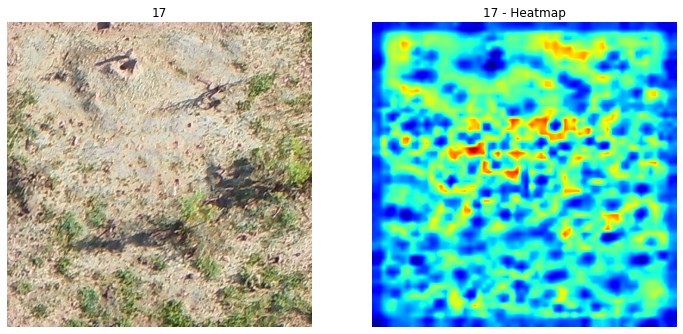

Shape of feature map for 20: (512, 32, 32)


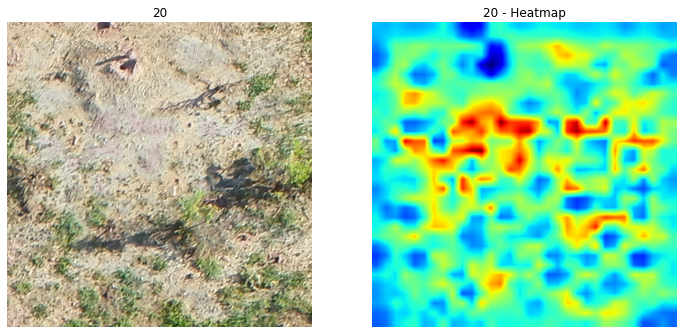

Shape of feature map for 23: (1024, 16, 16)


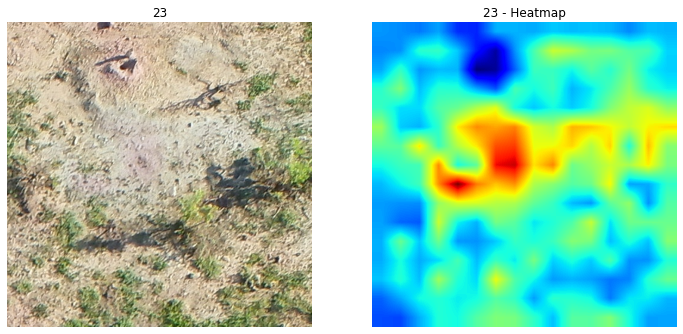

In [12]:
%matplotlib inline
model_path = "/data/home/bowen/projects/prairie_dog_2/yolov5_a100/weights/512data512model.pt"  # Change this to your trained model
image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run1_tiles/EnrNE_Day2_Run1__0040_0_12.jpg"  # Replace with your image path
# image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run2_tiles/EnrNE_Day2_Run2__0041_5_14.jpg"  # Replace with your image path
resized_image, features_model1 = get_features(image_path, model_path)
for layer_name, fmap in features_model1.items():
    overlay_feature_map(resized_image, fmap, layer_name)

### run12 3con

Fusing layers... 
YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs


Shape of feature map for P2 (Small Objects): (128, 128, 128)


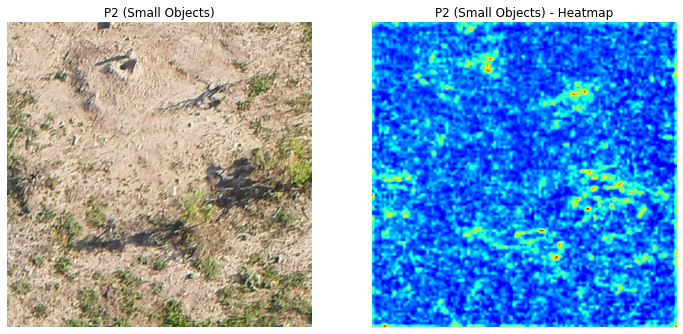

Shape of feature map for P3 (Small Objects): (256, 64, 64)


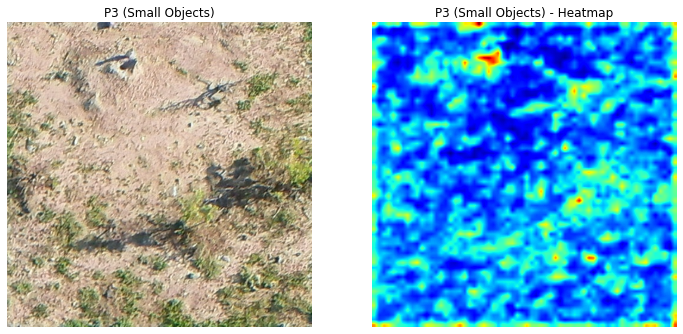

Shape of feature map for P4 (Medium Objects): (512, 32, 32)


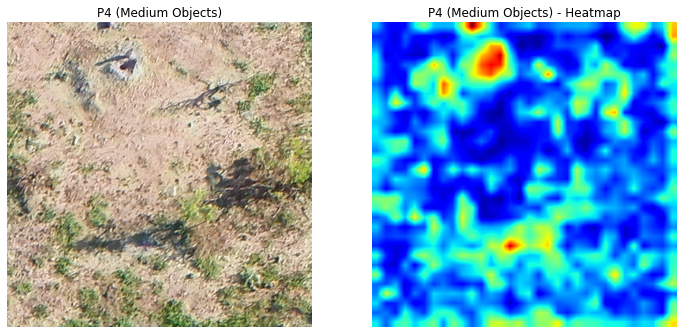

Shape of feature map for 17: (256, 64, 64)


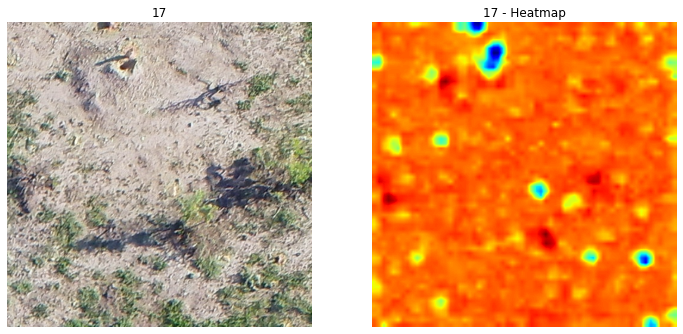

Shape of feature map for 20: (512, 32, 32)


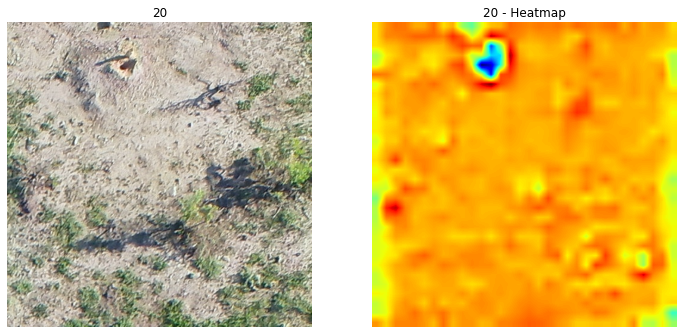

Shape of feature map for 23: (1024, 16, 16)


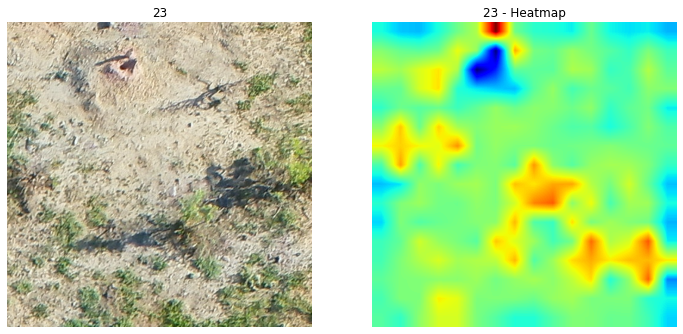

In [11]:
%matplotlib inline
model_path = "/data/home/bowen/projects/prairie_dog_2/yolov5_a100/weights/run12_3con_200e.pt"  # Change this to your trained model
image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run1_tiles/EnrNE_Day2_Run1__0040_0_12.jpg"  # Replace with your image path
# image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run2_tiles/EnrNE_Day2_Run2__0041_5_14.jpg"  # Replace with your image path
resized_image, features_model1 = get_features(image_path, model_path)
for layer_name, fmap in features_model1.items():
    overlay_feature_map(resized_image, fmap, layer_name)

### run12 3con Aug crop5

Fusing layers... 
YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs


Shape of feature map for P2 (Small Objects): (128, 128, 128)


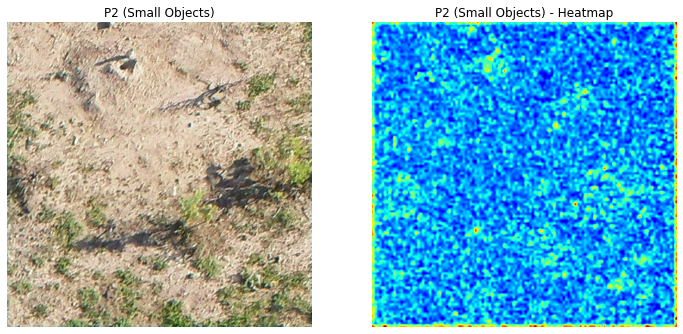

Shape of feature map for P3 (Small Objects): (256, 64, 64)


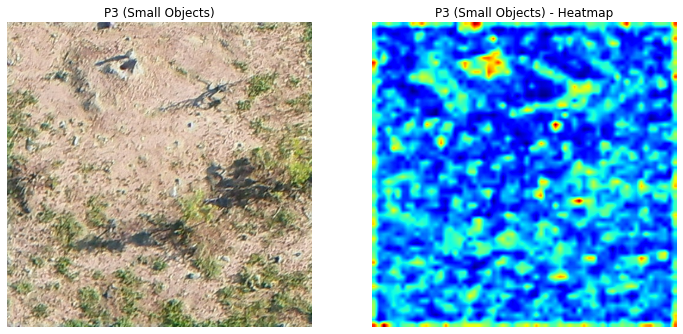

Shape of feature map for P4 (Medium Objects): (512, 32, 32)


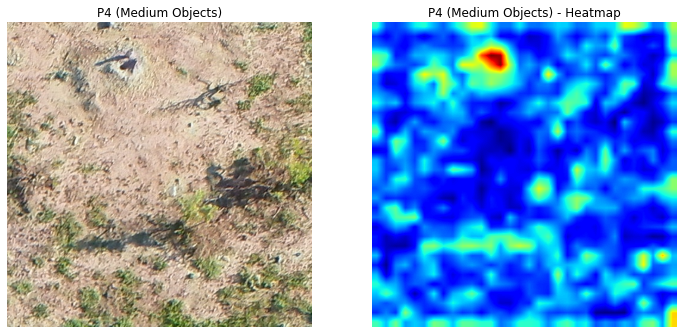

Shape of feature map for 17: (256, 64, 64)


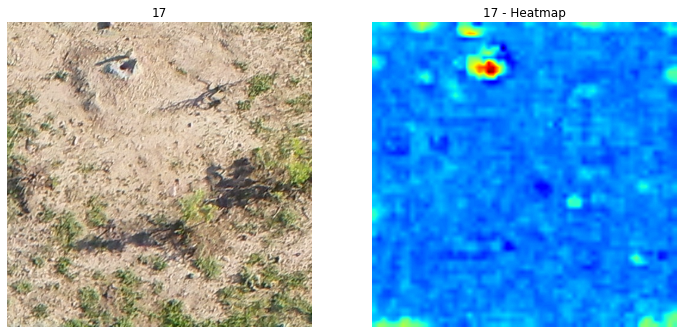

Shape of feature map for 20: (512, 32, 32)


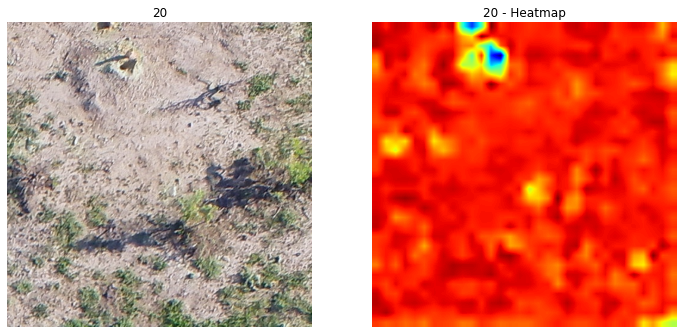

Shape of feature map for 23: (1024, 16, 16)


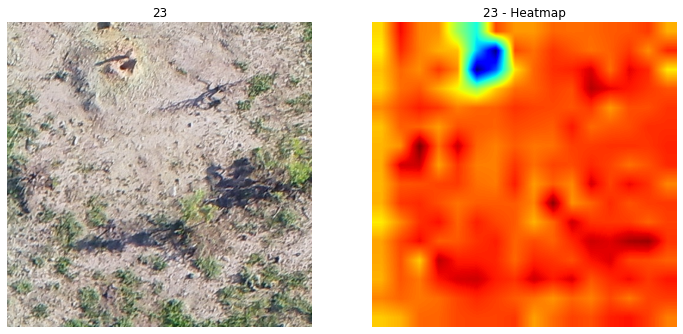

In [13]:
model_path = "/data/home/bowen/projects/prairie_dog_2/yolov5_a100/weights/run12_3con_crop5_200e.pt"  # Change this to your trained model
image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run1_tiles/EnrNE_Day2_Run1__0040_0_12.jpg"  # Replace with your image path
# image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run2_tiles/EnrNE_Day2_Run2__0041_5_14.jpg"  # Replace with your image path
resized_image, features_model1 = get_features(image_path, model_path)
for layer_name, fmap in features_model1.items():
    overlay_feature_map(resized_image, fmap, layer_name)

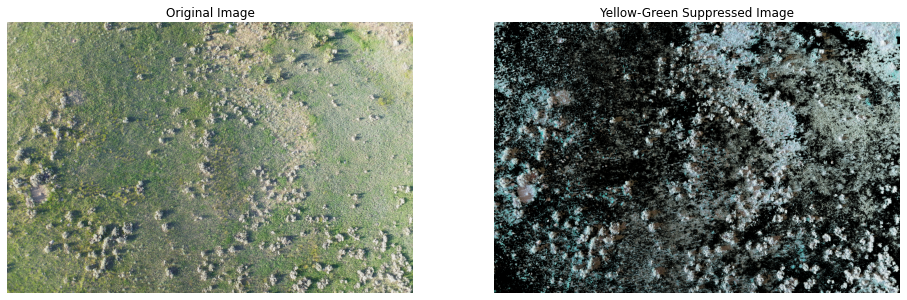

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run2_tiles/EnrNE_Day2_Run2__0041_5_14.jpg"  # Replace with your image path
image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/two_classes/run1_run2_yolo/images/run1_tiles/EnrNE_Day2_Run1__0040_0_12.jpg"  # Replace with your image path
image_path = "/data/home/bowen/projects/prairie_dog_2/data/old_data/run1/run1_yolo/images/train/EnrNE_Day2_Run1__0027.jpg"  # Replace with your image path

image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def suppress_yellow_green(image):
    # Convert RGB image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define yellow-green range in HSV (adjust thresholds as needed)
    lower_yellow_green = np.array([25, 40, 40])  # Hue for yellow-green
    upper_yellow_green = np.array([85, 255, 255])

    # Create mask for yellow-green areas
    mask = cv2.inRange(hsv_image, lower_yellow_green, upper_yellow_green)

    # Invert mask to focus on non-yellow-green areas
    inverse_mask = cv2.bitwise_not(mask)

    # Apply the mask to suppress yellow-green background
    suppressed_image = cv2.bitwise_and(image, image, mask=inverse_mask)

    return suppressed_image

sup_image = suppress_yellow_green(image)

# show image and sub_image side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].axis("off")
axes[0].set_title("Original Image")

axes[1].imshow(sup_image)
axes[1].axis("off")
axes[1].set_title("Yellow-Green Suppressed Image")

plt.show()
